In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Look at RF for package
import numpy as np
import tensorflow as tf
import pylab as pl
% pylab inline
RANDOM_SEED = np.random.seed(20170301)

Populating the interactive namespace from numpy and matplotlib


# Simple MLP using tensor flow
Adapted from a basic feedforward MLP developed by Vinh Khuc https://gist.github.com/vinhkhuc/e53a70f9e5c3f55852b0

1 hidden layer

In [2]:
data_directory = # set path to the directory with the following processed csvs here as string

# get 2013, 2014, and 2015 data for zipcode
init_zip_2013 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_zipcode_2013.csv')
init_zip_2014 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_zipcode_2014.csv')
init_zip_2015 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_zipcode_2015.csv')

In [3]:
def preprocess_and_split(train_data,test_data):
    """Takes initial dataframes for train and test/validate, processes, 
    and returns x_train, y_train,x_test,y_test.
    This is for the initial training/cross-validation only."""
    
    # replace 0 and inf and error zipcode
    # train
    train_data.fillna(0, inplace=True)
    train_data = train_data.replace(np.inf, 0)
    train_data = train_data[~train_data['ZipCode'].isin(['0',0])]
#     train_data = train_data.drop(['geometry', 'AREA','total_gas_incidents'],axis=1).copy()
    train_data = train_data.drop(['geometry', 'AREA','gas_incidents_per_bldg_unit'],axis=1).copy()
    
    # test/validate
    test_data.fillna(0, inplace=True)
    test_data = test_data.replace(np.inf, 0)
    test_data = test_data[~test_data['ZipCode'].isin(['0',0])]
#     test_data = test_data.drop(['geometry', 'AREA','total_gas_incidents'],axis=1).copy()
    test_data = test_data.drop(['geometry', 'AREA','gas_incidents_per_bldg_unit'],axis=1).copy()

    
    # add variables to training data for columns in test/validate data and set value to 0.0
    for i in train_data.columns:
        if i not in test_data.columns:
            test_data[i] = 0.0
            
    # drop excess features from test/validate data not found in train data and re-order
    test_data = test_data[train_data.columns]
    
    # set out features and target (target: gas leaks per unit per zip)
    x_train = train_data.iloc[:,1:-1].values # not include zipcode column
    y_train = train_data.iloc[:,-1].values
    
    # scale the data with minmax
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    
    # add bias vector as column to features
    b = np.ones((x_train.shape[0],x_train.shape[1]+1))
    b[:,:-1] = x_train
    x_train = b.copy()
    
    # test data (using train data features as test features)
    x_test = x_train.copy()
    y_test = test_data.iloc[:,-1].values
       
    return x_train,x_test,y_train,y_test

In [4]:
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

In [5]:
def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    """
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

In [7]:
def mlp(train_data,test_data,num_epochs=100,lr=0.01):
    train_X, test_X, train_y, test_y = preprocess_and_split(train_data,test_data)

    # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: x features and 1 bias
    h_size = 256                # Number of hidden nodes, this is arbitrary
    y_size = 1                  # Just 1 target variable

    # Symbols
    X = tf.placeholder("float", shape=[None, x_size])
    y = tf.placeholder("float", shape=[None, y_size])

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    w_2 = init_weights((h_size, y_size))

    # Forward propagation
    yhat    = forwardprop(X, w_1, w_2)

    # Backward propagation
    cost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, yhat)))) # root mean sq error
    updates = tf.train.GradientDescentOptimizer(lr).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    print_count = 0
    for epoch in range(num_epochs):

        # Train with each example
        for i in range(len(train_X)):
            sess.run(updates, feed_dict={X: train_X[i: i + 1],
                                         y: train_y[i: i + 1].reshape(1,1)})

        # test and validate the trained model
        train_run = sess.run(yhat, feed_dict={X: train_X, y: train_y.reshape(len(train_y),1)})
        test_run = sess.run(yhat, feed_dict={X: test_X, y: test_y.reshape(len(test_y),1)})
        
        train_accuracy = np.sqrt(np.mean((train_y - train_run)**2))
        test_accuracy = np.sqrt(np.mean((test_y - test_run)**2))

        if print_count>50:
            print "Epoch = {}, train rmse = {:.2f}, test rmse = {:.2f}, IS/OS ratio = {:.2f}%".format(
                epoch+1,train_accuracy, test_accuracy,train_accuracy/test_accuracy)
            print_count=0
        else:
            print_count+=1


    return test_run
    sess.close()

In [17]:
def run_and_plot(train,test,iters,lr):
    results = mlp(train,test,iters,lr)
    
    results_df = init_zip_2014[['ZipCode','total_gas_incidents']].copy()
    results_df['2013'] = init_zip_2013['total_gas_incidents'].copy()
    results_df = results_df[results_df.ZipCode!=0]
    results_df['yhat'] = results
    results_df = results_df.sort_values('total_gas_incidents',ascending=False).reset_index()
    
    # plot
    fig = pl.figure(figsize=(15,5))
    x = results_df.index
    pl.plot(x,results_df.total_gas_incidents,label='actual 2014 gas leaks per zip');
    pl.plot(x,results_df.yhat,label='predicted gas leaks per zip')
    pl.plot(x,results_df['2013'],label='2013 leaks, i.e. naive guess')
    pl.xlabel('zipcodes ranked in descending order of actual 2014 gas leaks')
    pl.ylabel('total gas leaks per zip')
    pl.legend(loc='best')
    pl.title("Actual 2014 vs MLP predicted 2014; {} epochs, lr={}".format(iters,lr));
    
    fig1 = pl.figure(figsize=(15,5))
    pl.plot(results_df['total_gas_incidents']-results_df['yhat'],'g')
    pl.title('difference b/t 2014 gas_incidents and NN model output')
    pl.xlabel('zipcodes ranked in descending order of actual 2014 gas leaks')
    pl.ylabel('diff in 2014 actual from 2014 predicted')

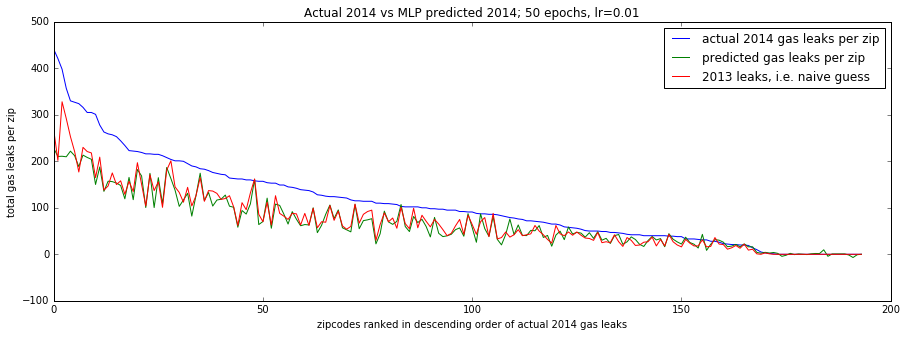

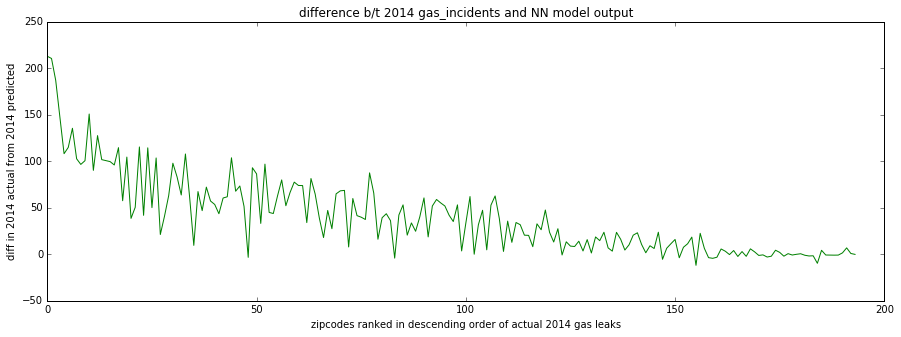

In [18]:
new_epoch = 50
new_lr = 0.01
run_and_plot(init_zip_2013,init_zip_2014,iters=new_epoch,lr=new_lr)